https://www.kaggle.com/datasets/olafkrastovski/handwritten-digits-0-9/data

In [395]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader,Dataset
import torchvision
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import os

In [396]:
image_paths = []

for x in os.listdir('C:/Users/fidyt/Desktop/ML/Handwritten Digits 0 - 9 GAN/images'):
    for i in os.listdir(f'C:/Users/fidyt/Desktop/ML/Handwritten Digits 0 - 9 GAN/images/{x}'):
        image_paths.append(f'C:/Users/fidyt/Desktop/ML/Handwritten Digits 0 - 9 GAN/images/{x}/{i}')

In [397]:
transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5))
])
latent_dim=512

In [398]:
class CustomDataSet(Dataset):
    def __init__(self,images_path,transforms=None):
        super().__init__()
        self.images = images_path
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        return image


In [399]:
train_dataset = CustomDataSet(image_paths,transforms)


In [400]:
import random

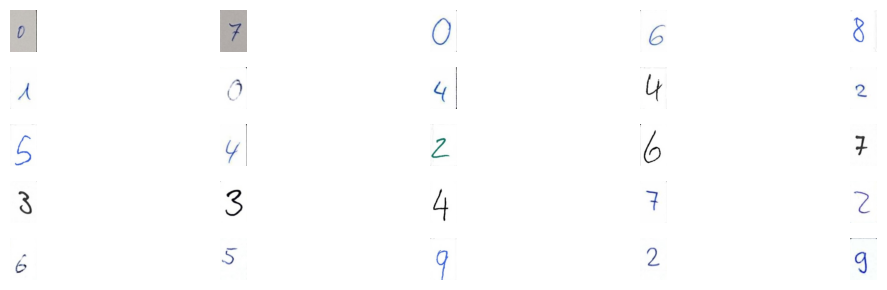

In [401]:
f,axs = plt.subplots(5,5,figsize=(12,3))
for c in range(5):
    for r in range(5):
        image =Image.open(random.choice(image_paths)).convert('RGB')
        axs[c,r].imshow(image)
        axs[c,r].axis('off')
plt.tight_layout()

In [402]:
BATCH_SIZE = 32
EPOCHS = 20
LR=2e-4
BETAS=(0.5,0.999)

In [403]:
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [404]:
for x in train_dataset:
    print(x.shape)
    break

torch.Size([3, 64, 64])


In [405]:
from torch.nn.utils import spectral_norm

In [406]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential=nn.Sequential(
            spectral_norm(nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False)),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(.2,inplace=True),

            spectral_norm(nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False)),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(.2,inplace=True),

            spectral_norm(nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False)),
            #nn.BatchNorm2d(256),
            nn.LeakyReLU(.2,inplace=True),

            spectral_norm(nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False)),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(.2,inplace=True),

            # nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(.2,inplace=True),

            spectral_norm(nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False)),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )      
    def forward(self,x):
        x = self.sequential(x)
        return x

In [407]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential =nn.Sequential(
            nn.ConvTranspose2d(latent_dim,1024,kernel_size=4,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1,bias=False),
            # nn.BatchNorm2d(32),
            # nn.ReLU(True),

            nn.ConvTranspose2d(128,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )

    def forward(self,x):
        x=self.sequential(x)
        return x

In [408]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [409]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

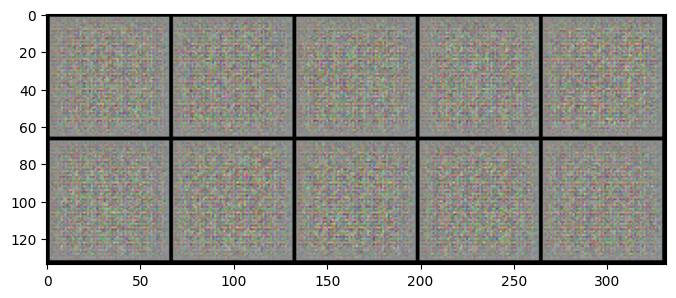

In [410]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
latent_space = torch.randn(10,latent_dim,1,1,device=device)

with torch.no_grad():
    generator.eval()
    fake_images = generator(latent_space)

grid = make_grid(fake_images,nrow=5,normalize=True).cpu()
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [411]:
criterion = nn.BCEWithLogitsLoss()
optimizerD =Adam(discriminator.parameters(),lr=LR,betas=BETAS)
optimizerG =Adam(generator.parameters(),lr=LR,betas=BETAS)
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (sequential): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
)

In [412]:
for epoch in range(EPOCHS):
    generator.train()
    discriminator.train()
    for real_image in tqdm(train_dataloader,desc='Training'):
        real_image = real_image.to(device)
        batch_size = real_image.size(0)

        real_labels = torch.ones(batch_size,1,device=device) *.9
        fake_labels = torch.zeros(batch_size,1,device=device)
        #first discriminator
        optimizerD.zero_grad()
        real_outputs = discriminator(real_image)
        real_loss = criterion(real_outputs,real_labels)

        z=torch.randn(batch_size,latent_dim,1,1,device=device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs,fake_labels)

        lossD =real_loss+fake_loss
        lossD.backward()
        optimizerD.step()

        # generator update

        optimizerG.zero_grad()
        fake_outputs = discriminator(fake_images)
        lossG = criterion(fake_outputs,real_labels)
        lossG.backward()
        optimizerG.step()
    
    print(f'Epoch: {epoch+1}/{EPOCHS} , lossD: {lossD.item():.2f}, lossG: {lossG.item():.2f}')


Training: 100%|██████████| 674/674 [00:26<00:00, 25.84it/s]


Epoch: 1/20 , lossD: 1.10, lossG: 1.60


Training: 100%|██████████| 674/674 [00:27<00:00, 24.65it/s]


Epoch: 2/20 , lossD: 1.35, lossG: 0.93


Training: 100%|██████████| 674/674 [00:26<00:00, 25.24it/s]


Epoch: 3/20 , lossD: 1.24, lossG: 0.98


Training: 100%|██████████| 674/674 [00:26<00:00, 25.71it/s]


Epoch: 4/20 , lossD: 1.21, lossG: 1.07


Training: 100%|██████████| 674/674 [00:26<00:00, 25.64it/s]


Epoch: 5/20 , lossD: 1.28, lossG: 0.70


Training: 100%|██████████| 674/674 [00:27<00:00, 24.69it/s]


Epoch: 6/20 , lossD: 1.24, lossG: 0.98


Training: 100%|██████████| 674/674 [00:25<00:00, 26.85it/s]


Epoch: 7/20 , lossD: 1.26, lossG: 1.13


Training: 100%|██████████| 674/674 [00:24<00:00, 27.57it/s]


Epoch: 8/20 , lossD: 1.19, lossG: 1.02


Training: 100%|██████████| 674/674 [00:24<00:00, 27.48it/s]


Epoch: 9/20 , lossD: 1.15, lossG: 0.95


Training: 100%|██████████| 674/674 [00:24<00:00, 27.51it/s]


Epoch: 10/20 , lossD: 1.28, lossG: 0.98


Training: 100%|██████████| 674/674 [00:24<00:00, 27.53it/s]


Epoch: 11/20 , lossD: 1.27, lossG: 0.88


Training: 100%|██████████| 674/674 [00:24<00:00, 27.62it/s]


Epoch: 12/20 , lossD: 1.15, lossG: 1.03


Training: 100%|██████████| 674/674 [00:24<00:00, 27.56it/s]


Epoch: 13/20 , lossD: 1.20, lossG: 0.88


Training: 100%|██████████| 674/674 [00:24<00:00, 27.61it/s]


Epoch: 14/20 , lossD: 1.28, lossG: 1.18


Training: 100%|██████████| 674/674 [00:24<00:00, 27.57it/s]


Epoch: 15/20 , lossD: 1.26, lossG: 1.03


Training: 100%|██████████| 674/674 [00:24<00:00, 27.68it/s]


Epoch: 16/20 , lossD: 1.26, lossG: 1.07


Training: 100%|██████████| 674/674 [00:24<00:00, 27.50it/s]


Epoch: 17/20 , lossD: 1.17, lossG: 1.05


Training: 100%|██████████| 674/674 [00:24<00:00, 27.57it/s]


Epoch: 18/20 , lossD: 1.24, lossG: 1.03


Training: 100%|██████████| 674/674 [00:24<00:00, 27.48it/s]


Epoch: 19/20 , lossD: 1.45, lossG: 0.90


Training: 100%|██████████| 674/674 [00:24<00:00, 27.60it/s]

Epoch: 20/20 , lossD: 1.32, lossG: 0.95


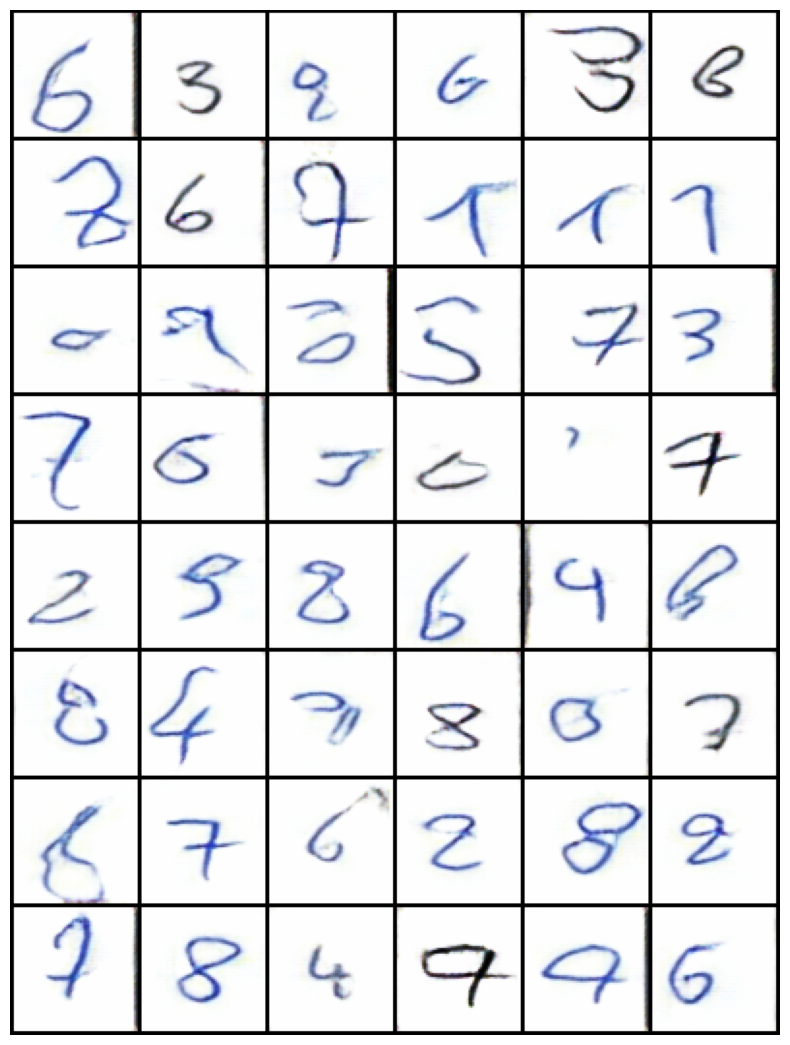

In [425]:
generator.eval()
generator.to(device)
batch_size = 48
z=torch.randn(batch_size,latent_dim,1,1,device=device)

with torch.no_grad():
    generated_images = generator(z)


grid = make_grid(generated_images,nrow=6,normalize=True)
plt.figure(figsize=(8,12))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis('off')
plt.tight_layout()
plt.show()